In [199]:
import pandas as pd
import numpy as np
from numpy import mean
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [33]:
df = pd.read_csv('data.csv')

In [34]:
def calError(row):
    if row['TOTAL'] == 0:
        val = 0
    else:
        val = (row['QTYERROR'] / row['TOTAL']) * 100
    return val

df['TOTAL'] =  df[['QTYERROR', 'QTYGOOD']].sum(axis=1)
df['ERROR_RATE'] = df.apply(calError, axis=1)

In [35]:
df.nunique()

JobId           6
ITEMID         27
OprID          30
WORKER         15
WrkCtrID       38
Hours         204
QTYERROR       11
QTYGOOD       140
TOTAL         140
ERROR_RATE      5
dtype: int64

In [36]:
df['ERROR_RATE'].unique()

array([0.        , 0.25316456, 0.52910053, 0.27173913, 0.27434842])

In [243]:
Counter(df['ERROR_RATE'])

Counter({0.0: 241,
         0.25316455696202533: 4,
         0.5291005291005291: 4,
         0.2717391304347826: 4,
         0.2743484224965706: 4})

In [22]:
df.describe()

,JobId,WORKER,Hours,QTYERROR,QTYGOOD,TOTAL,ERROR_RATE
count,24.000000,2.570000e+02,257.000000,257.000000,257.000000,257.000000,257.000000
mean,5427.166667,9.833958e+09,2814.820371,3.182879,13562.128405,13565.311284,0.020675
std,378.792781,1.121114e+10,5102.619501,15.069423,46277.283085,46278.110359,0.085301
min,4598.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5591.000000,0.000000e+00,134.200000,0.000000,0.000000,0.000000,0.000000
50%,5592.000000,0.000000e+00,733.150207,0.000000,610.000000,610.000000,0.000000
75%,5594.000000,2.256542e+10,2706.182985,0.000000,10560.000000,10560.000000,0.000000
max,5595.000000,2.256542e+10,33660.000000,122.000000,363350.000000,363350.000000,0.529101


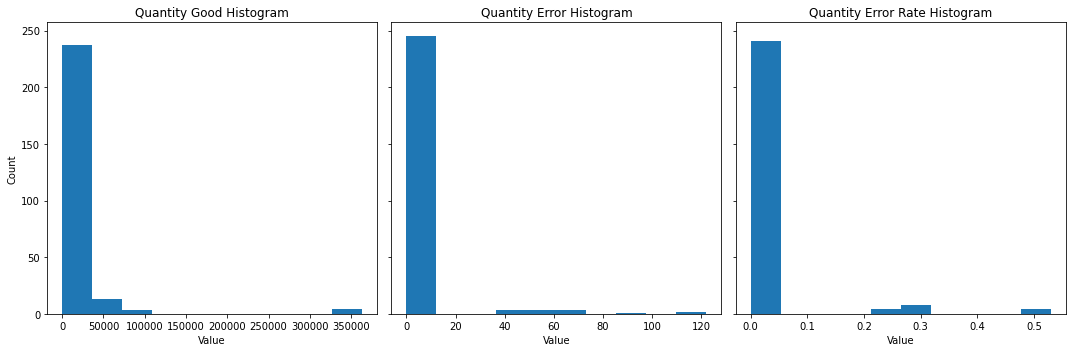

In [23]:
n_bins=10

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))
for i in range(3):
    axs[i].set_xlabel('Value')

axs[0].set_ylabel('Count')
axs[0].hist(df['QTYGOOD'], bins=n_bins)
axs[0].set_title('Quantity Good Histogram')
axs[1].hist(df['QTYERROR'], bins=n_bins)
axs[1].set_title('Quantity Error Histogram')
axs[2].hist(df['ERROR_RATE'], bins=n_bins)
axs[2].set_title('Quantity Error Rate Histogram')
plt.show()

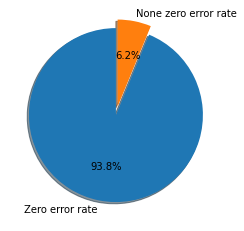

In [249]:
errorRateZero, errorRateNoneZero = 0, 0
for key, val in Counter(df['ERROR_RATE']).items():
    if key == 0:
        errorRateZero += val
    else:
        errorRateNoneZero += val

plt.pie([errorRateZero, errorRateNoneZero], labels=['Zero error rate', 'None zero error rate'], explode=[0,0.1], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

In [255]:
def plotCategory(field):
    items = df[field].value_counts()
    plt.figure(figsize=(15, 5))
    plt.bar(items.keys(), items.values)
    plt.xticks(rotation=45)
    plt.show()

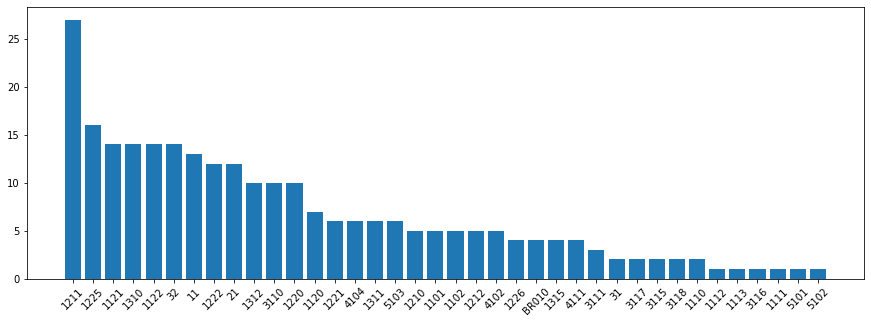

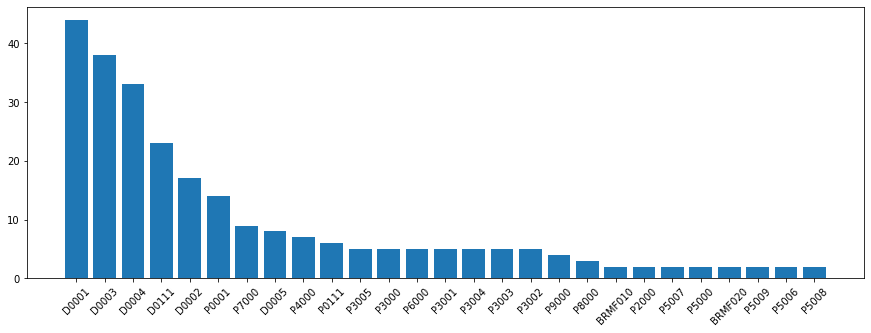

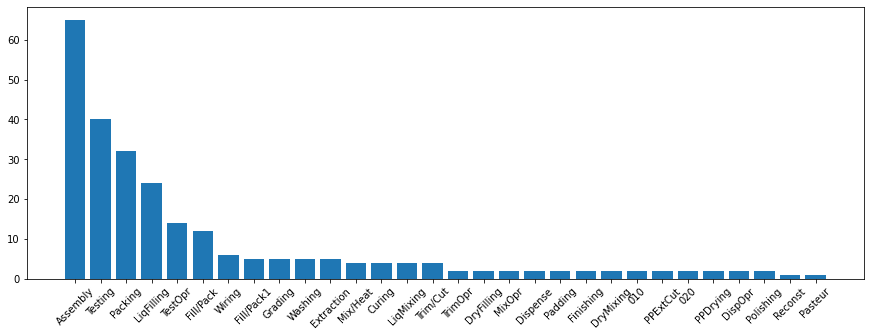

In [257]:
plotCategory('WrkCtrID')
plotCategory('ITEMID')
plotCategory('OprID')

# Preprocessing and feature engineering

In [125]:
features = ['ITEMID', 'OprID', 'WORKER', 'WrkCtrID']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrID')] = data['WrkCtrID'].astype(str)
# X = data.to_numpy()
X = data.loc[:]
y = df['ERROR_RATE'].astype(str)

In [126]:
Counter(y)

Counter({'0.0': 241,
         '0.25316455696202533': 4,
         '0.5291005291005291': 4,
         '0.2717391304347826': 4,
         '0.2743484224965706': 4})

In [49]:
def getMajorityClass(d):
    max_ = -1
    majority = None
    for key, val in d.items():
        if val > max_:
            majority = key
            max_ = val
    return majority

In [127]:
labelDict = Counter(y)
overSampleRate = 0.5
maj = getMajorityClass(labelDict)
majorityCount = labelDict[maj]
sampleDict = {key: int(overSampleRate * majorityCount) for key in labelDict.keys() if key != maj}

In [258]:
# TODO: class weight

In [223]:
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
over = SMOTE(sampling_strategy=sampleDict, random_state=42, k_neighbors=3)
under = RandomUnderSampler(sampling_strategy='majority')
# model = DecisionTreeClassifier(random_state=0)
model = RandomForestClassifier(random_state=42)
steps = [('encoding', enc), ('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X, y)

# Training and validating

In [224]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_res, y_res, cv=cv, n_jobs=-1)
print('cross_val_score: %.3f' % mean(scores))

cross_val_score: 0.993


In [228]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=0)
model.fit(X_train, y_train)
print('Score for train data', model.score(X_train, y_train))
print('Score for test data', model.score(X_test, y_test))

Score for train data 0.9955555555555555
Score for test data 1.0


In [226]:
Counter(y_test)

Counter({'0.2743484224965706': 32,
         '0.25316455696202533': 28,
         '0.5291005291005291': 32,
         '0.2717391304347826': 29,
         '0.0': 29})

# Feature importance

## Decision Tree feature importance

<ipython-input-163-76756d740c97>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


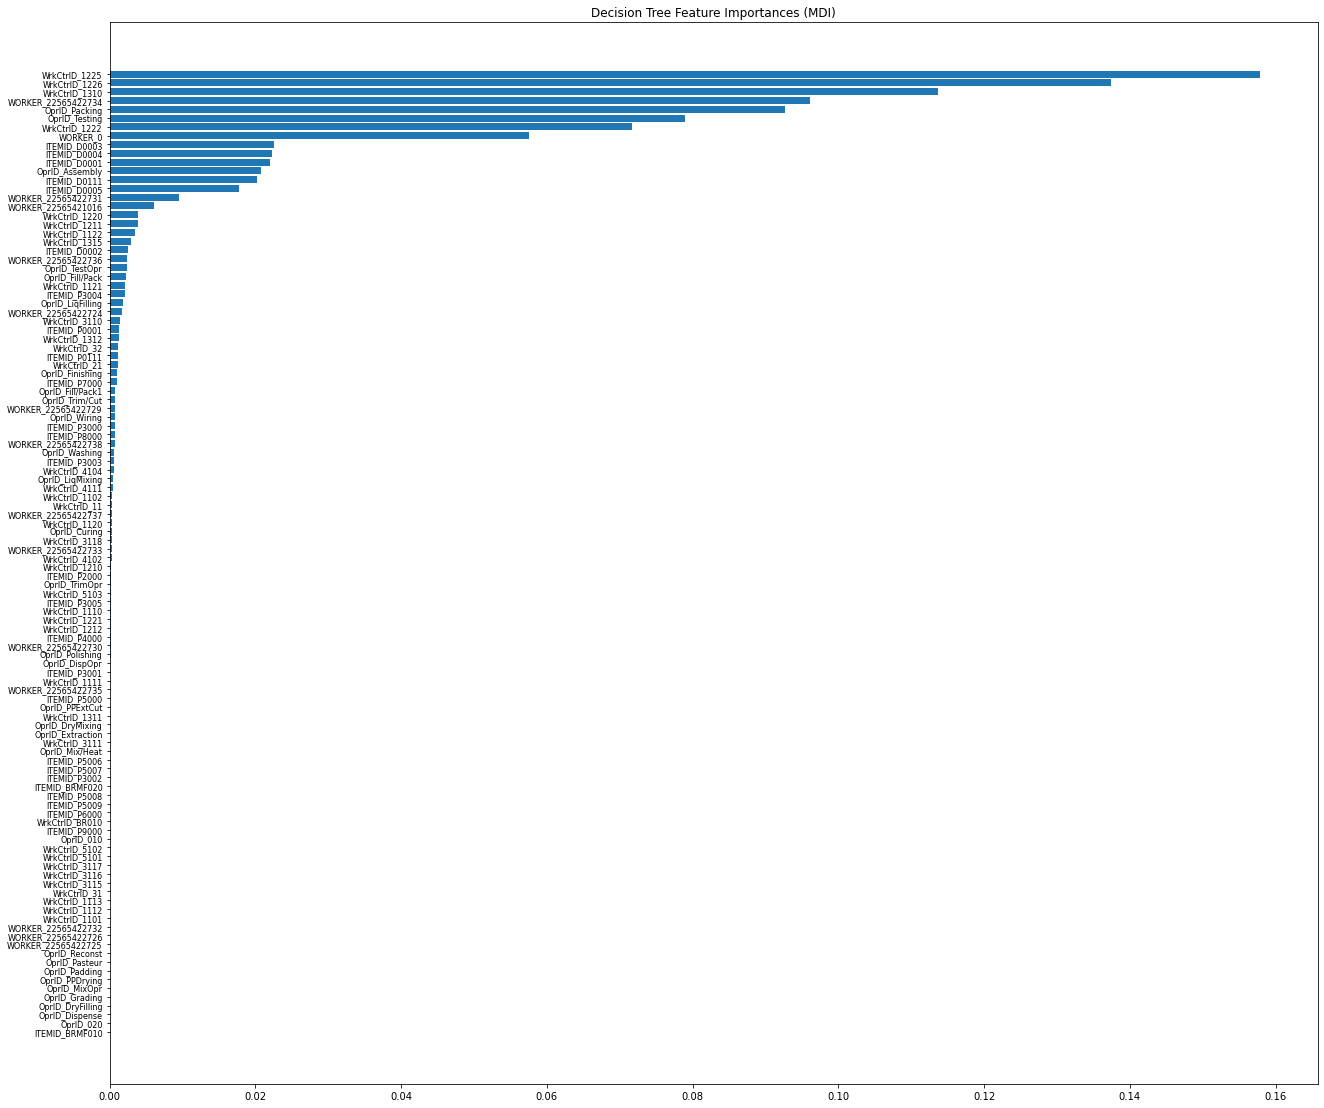

In [163]:
feature_names = pipeline.named_steps['encoding'].get_feature_names(list(X.columns))
tree_feature_importances = (model.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Decision Tree Feature Importances (MDI)")
fig.set_size_inches(18.5, 15.5)
plt.tick_params(axis='y', which='major', labelsize=8)
fig.tight_layout()
plt.show()

## Permutation feature importance

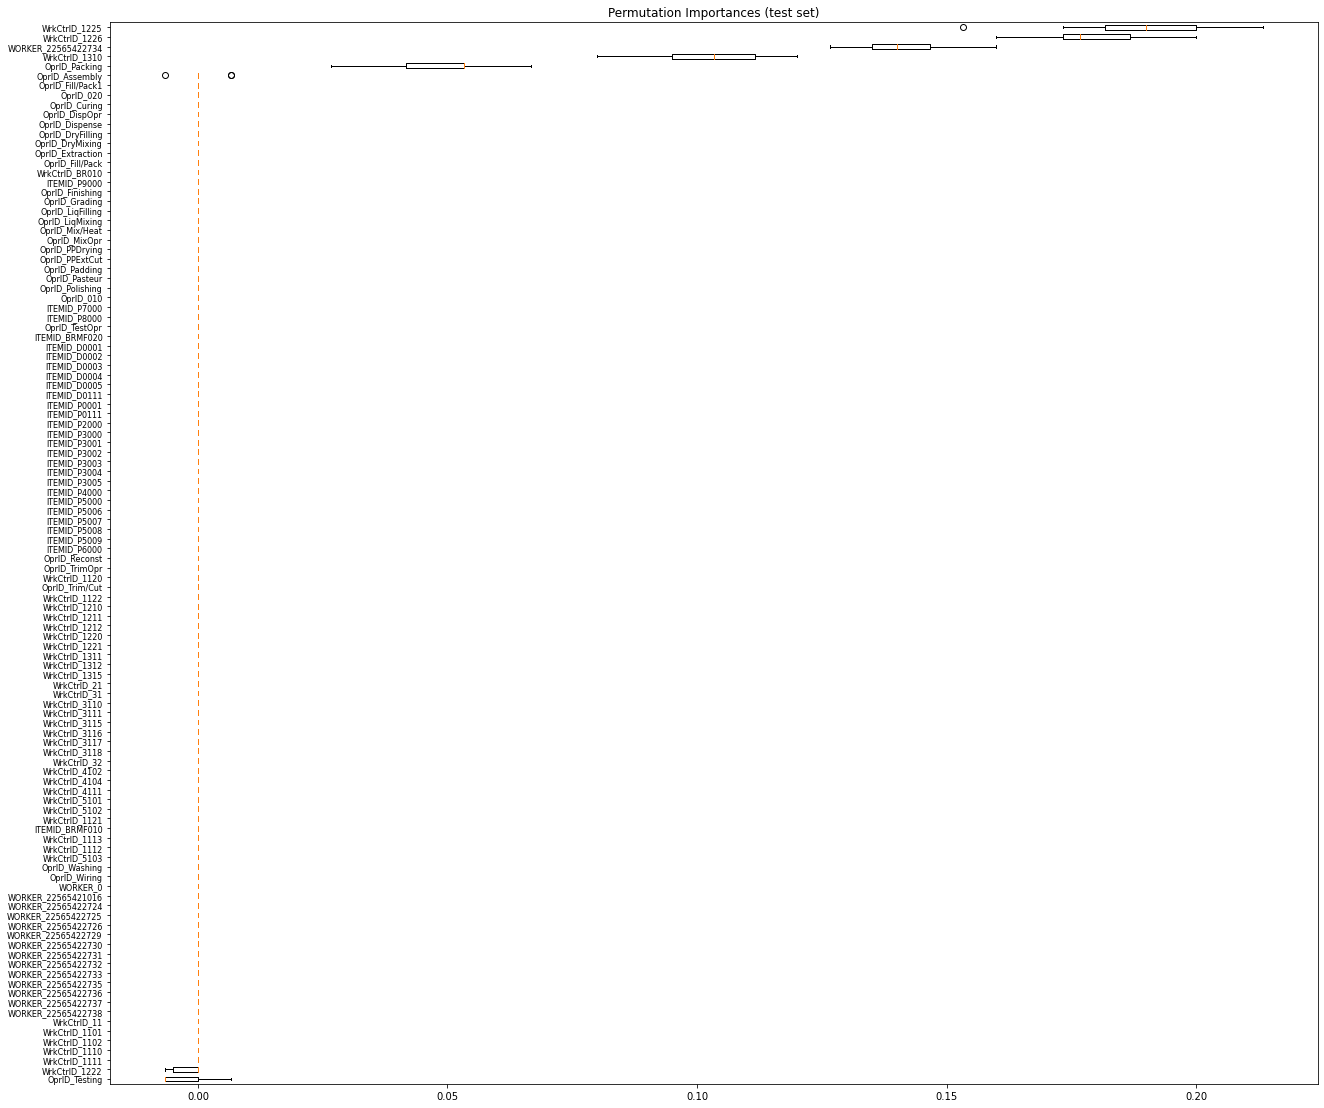

In [178]:
result = permutation_importance(model, X_test.todense(), y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=feature_names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.set_size_inches(18.5, 15.5)
plt.tick_params(axis='y', which='major', labelsize=8)
fig.tight_layout()
plt.show()

## Multicollinear Features

In [240]:
# Select features that contribute to the model
X_res_df = pd.DataFrame(X_res.toarray(), columns = feature_names)
# selected_features = [item[1] for item in zip(tree_feature_importances[sorted_idx], feature_names[sorted_idx]) if item[0] != 0]
selected_features = feature_names[sorted_idx][-10:]
X_res_selected = X_res_df.loc[:, selected_features]

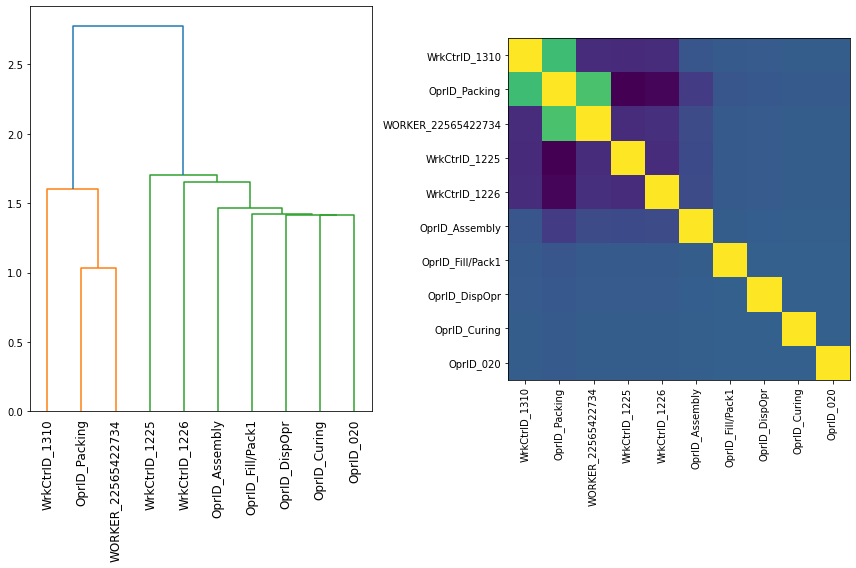

In [242]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_res_selected).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=list(selected_features), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()